## 在开始之前

> 提示：为防止各种意外情况，请大家常按<kbd>Ctrl</kbd>+<kbd>s</kbd>对文档进行保存。

> 提示：在继续前，请切换至正确的内核。
> - 如果使用我们的整合包，请切换到`EST1601`内核
> - 如果使用交我算平台，请切换到`torch_2.0.1`内核
> 
> 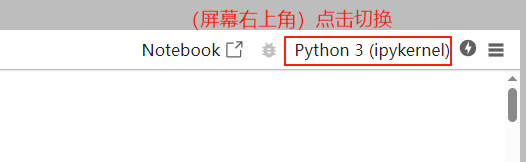

通过刚才的预实验，想必大家已经跃跃欲试，想亲手构建、训练一个模型了！话不多说，让我们开始吧！

首先，导入一些本次实验会用到的包，及进行一些必要的初始化。

In [11]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *

# 统一随机数种子
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# 判断是否有卡用
if torch.cuda.is_available(): # CUDA(英伟达系列GPU)
	my_device = "cuda"
elif torch.backends.mps.is_available(): # 苹果M系列芯片
	my_device = "mps"
else:
	my_device = "cpu"

print(my_device)
# 准备一张测试图片
from PIL import Image
import requests
from io import BytesIO

url = "https://est1601-resource.881222.xyz/horse.jpg"
response = requests.get(url)
if response.status_code == 200:
    image_data = BytesIO(response.content)
    test_image = Image.open(image_data)
else:
    print(f"Failed to retrieve image. Status code: {response.status_code}")

cuda


## 数据预处理与准备数据集

**在本实验中，我们将使用CIFAR-10作为数据集**。该数据集包含来自10个类别的图像，**每个图像的尺寸为3x32x32**，即3通道彩色图像，尺寸为32x32像素。


**但，在进行训练前，我们往往需要对图像进行预处理**。**恰好`torchvision.transforms`模块中实现了一些图像转换的类**，常用的如下表所示：

> 这些类都是`nn.Module`的子类，这意味着你可以在实例化类后，直接用`对象名(张量)`的形式获得张量输出结果。

| 操作（点击可看文档）         | 说明                                                                                      |
|------------|-----------------------------------------------------------------------------------------|
| [RandomCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomCrop.html#randomcrop) | 对输入图像进行随机位置裁剪 |
| [RandomHorizontalFlip](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html#randomhorizontalflip) | 以给定的概率随机水平翻转输入图像（概率默认为50%） |
| [ToPILImage](https://pytorch.org/vision/main/generated/torchvision.transforms.ToPILImage.html#topilimage) | 将数据格式为$(C,H,W)$的张量,或数据格式为$(H,W,C)$的NumPy数组转换成PIL图像                                            |
| [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html#totensor)   | 将数值范围在$[0, 255]$区间的PIL格式的图像，或数据格式为$(H,W,C)$的NumPy数组转换成$(C,H,W)$、`torch.float`类型的张量，数值范围为$[0.0, 1.0]$  |
| [Normalize](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)   | 对输入数据归一化                                                                                |
| [Resize](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html)     | 对输入图像调整大小                                                                               |
---

在一开始，我们准备了一张测试图片`test_image`。接下来，我们尝试将[`RandomHorizontalFlip`](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html#randomhorizontalflip)操作应用到这张图片上来。


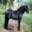

In [3]:
test_image # 先来看一下原图片

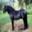

In [4]:
horizion_flip = RandomHorizontalFlip() # 默认以50%的概率水平翻转
horizion_flip(test_image) # 有可能翻了，也可能没翻（可以多执行几次这个代码块

如果要对图像做**多步**处理，**手动写**`x=操作1(x)`、`x=操作2(x)`、`x=操作3(x)`是很**烦**的。恰好[**`torchvision.transforms.Compose`类**](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html)可以将多个`transforms`操作**串连**在一起。

**接下来，我们分别针对测试集、训练集指定预处理转换规则**。

**请你根据注释提示和上述信息，替换掉下方代码块中的`!!CHANGEME!!`部分**。

In [5]:
transforms = {
  "train": Compose([ # 可将多个操作连在一起
    RandomCrop(32, padding=4), # 实例化了RandomCrop类，目的是随机裁剪图像为32x32大小，并在裁剪前对图像进行4像素的填充
    RandomHorizontalFlip(),    # 实例化？类，以50%的概率随机水平翻转图像
    ToTensor(),              # 实例化？类，鉴于数据集中的图像是PIL对象，需将图像数据转换为PyTorch张量格式
  ]),
  "test": ToTensor(),
}

**[`torchvision.datasets`包](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)中提供了一些常用数据集（包括CIFAR-10），可以在训练时直接加载使用**。

> 所有的`torchvision.datasets`中的内建数据集均继承了[`torch.utils.data.Dataset`类](https://pytorch.org/docs/2.6/data.html#torch.utils.data.Dataset)，允许我们**逐样本**检索数据集的特征和标签（i.e. 直接用`数据集[index]`可查看第`index`个样本）。

通过`torchvision.datasets`加载数据集十分容易，像下面这样直接调用就好了。**我们在上方定义了转换规则，接下来请你替换掉下方代码块中的`!!CHANGEME!!`部分，使之能够根据循环中`split`变量的值，从我们上方`transforms`词典中选择对应的转换规则。**

In [7]:
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",              # 数据集存放的路径
    train=(split == "train"),         # 指定训练集还是测试集
    download=True,                    # 如果路径中没有则联网下载
    transform=transforms[split]            # 指定转换规则
)

100.0%


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


这一段只是测试使用，可以跳过。我们可以展示数据集中的**一些**图像及其对应的类别标签。只是一些，放到sample里。**直接执行代码块即可，无需补充内容**。

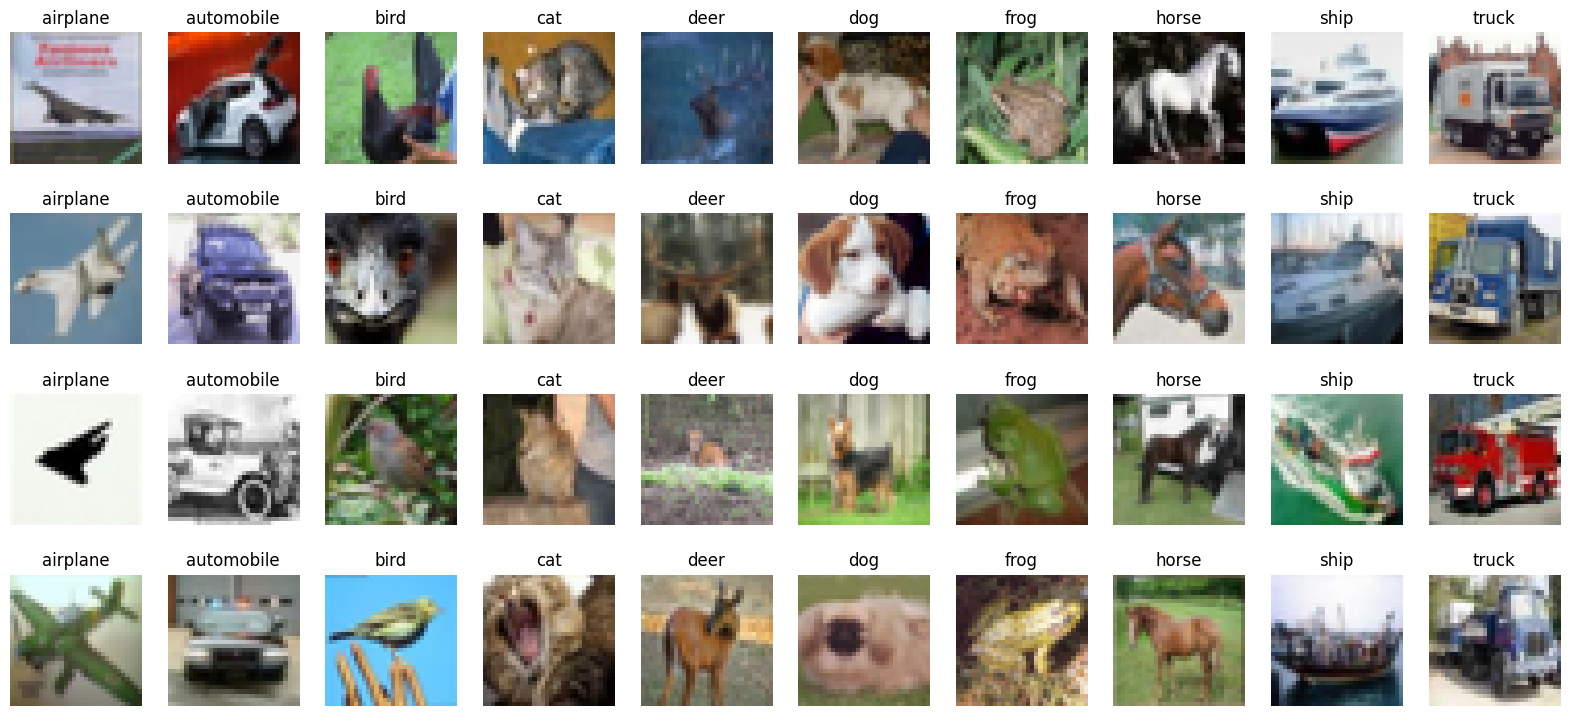

In [10]:
samples = [[] for _ in range(10)]  # 创建一个包含10个空列表的列表，用于存储每个类别的样本
for image, label in dataset["test"]: # 遍历测试数据集中的每个图像和标签
  if len(samples[label]) < 4: # 如果当前类别的样本数量少于4个
    samples[label].append(image) # 将图像添加到对应类别的样本列表中
#上面执行完后，得到的是sample，10个列表，每个列表4张图片

plt.figure(figsize=(20, 9)) # 创建一个大小为20x9的图像窗口

for index in range(40): # 遍历40个索引（4行，每行10个图像）
  label = index % 10 # 计算当前图像的类别标签（0到9）
  image = samples[label][index // 10] # 从对应类别的样本列表中获取图像

  # 将图像从通道-高度-宽度（CHW）格式转换为高度-宽度-通道（HWC）格式，这是matplotlib库要求的，没办法，随它便是
  image = image.permute(1, 2, 0) 

  # 将类别索引转换为类别名称
  label = dataset["test"].classes[label] 

  # 可视化图像
  plt.subplot(4, 10, index + 1) # 在4行10列的网格中定位当前图像的位置
  plt.imshow(image) # 显示图像
  plt.title(label) # 将类别名称作为图像标题
  plt.axis("off") # 关闭坐标轴显示
plt.show() # 显示图像

在训练模型时，我们通常以“**小批量梯度下降**”(Mini-Batch Gradient Descent)方法进行优化。基本思想是，在单次前向/反向过程中，使用一个**小批量样本**（所有样本中的**一部分**，而非所有样本）的**平均梯度**来近似全局梯度，以减少计算开销并提高收敛速度。**当训练集中所有样本都参与过一次参数更新时，称为训练一轮(epoch)**。

> 相对于传统梯度下降需要算所有样本，小批量梯度下降可以更快地进行参数更新，实现了计算效率和模型稳定性之间的平衡，是目前使用最广泛的一种梯度下降优化方法。



然而，`torch.utils.data.Dataset`只允许我们**一条数据一条数据地**的访问。恰好[`DataLoader`类](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader`)（[`torch.utils.data.DataLoader`类](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader`)）可以很方便的把样本分成若干Batch--仅需将`Dataset`类的实例传给`DataLoader`类，便可得到一个**数据加载器**。在每次迭代过程中，可返回**一批数据**。

**请你根据注释，补充下方代码块中的`!!CHANGEME!!`**。

In [12]:
dataflow = {}  # 初始化一个空字典，用于存储不同数据集划分（训练/测试）的数据加载器
for split in ['train', 'test']:  # 遍历训练集和测试集两种数据划分模式
  dataflow[split] = DataLoader(  # 为当前数据划分创建PyTorch DataLoader实例
    dataset=dataset[split],        # 从我们上面创建的dataset字典中，获取对应划分的数据集
    batch_size=256,     # 设置批次大小为256
    shuffle=(split == 'train'),  # 仅在训练时打乱数据顺序（增强泛化性）
    pin_memory=True,             # 将数据复制到固定内存，加速GPU数据传输
                                 #(同学们如果学计算机系统/计算机组成原理/计算机体系结构后就会明白啦，实质是不会被换掉的连续页)
  )

刚才我们提到，使用`DataLoader`的方式是：

> 通过`for`循环或其他方式遍历`DataLoader`实例：在每次迭代过程中，可返回一批数据。

现在，我们尝试遍历一下训练集，观察在单次迭代过程中，从中拿到的数据的形状，是不是**一批**数据？

> 回忆上文介绍数据集时提到过：**每张图片是3通道，尺寸为32x32像素**；结合下方代码块输出内容，相信你已有上面问题的答案了。

**直接执行代码块即可，无需补充内容**。

In [13]:
for inputs, targets in dataflow["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break # 循环一次就好了

[inputs] dtype: torch.float32, shape: torch.Size([256, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([256])


## 构建模型

在预实验中，我们详细的说明了如何使用`nn.Module`构建模型。在本次实验中，我们将构建**简化**的[VGG-11](https://arxiv.org/abs/1409.1556)模型。

模型的架构图如下（可以[点击这里](https://notes.sjtu.edu.cn/PS4AKVGSRQCPz6_9yW59GQ?view)在新窗口中查看）：

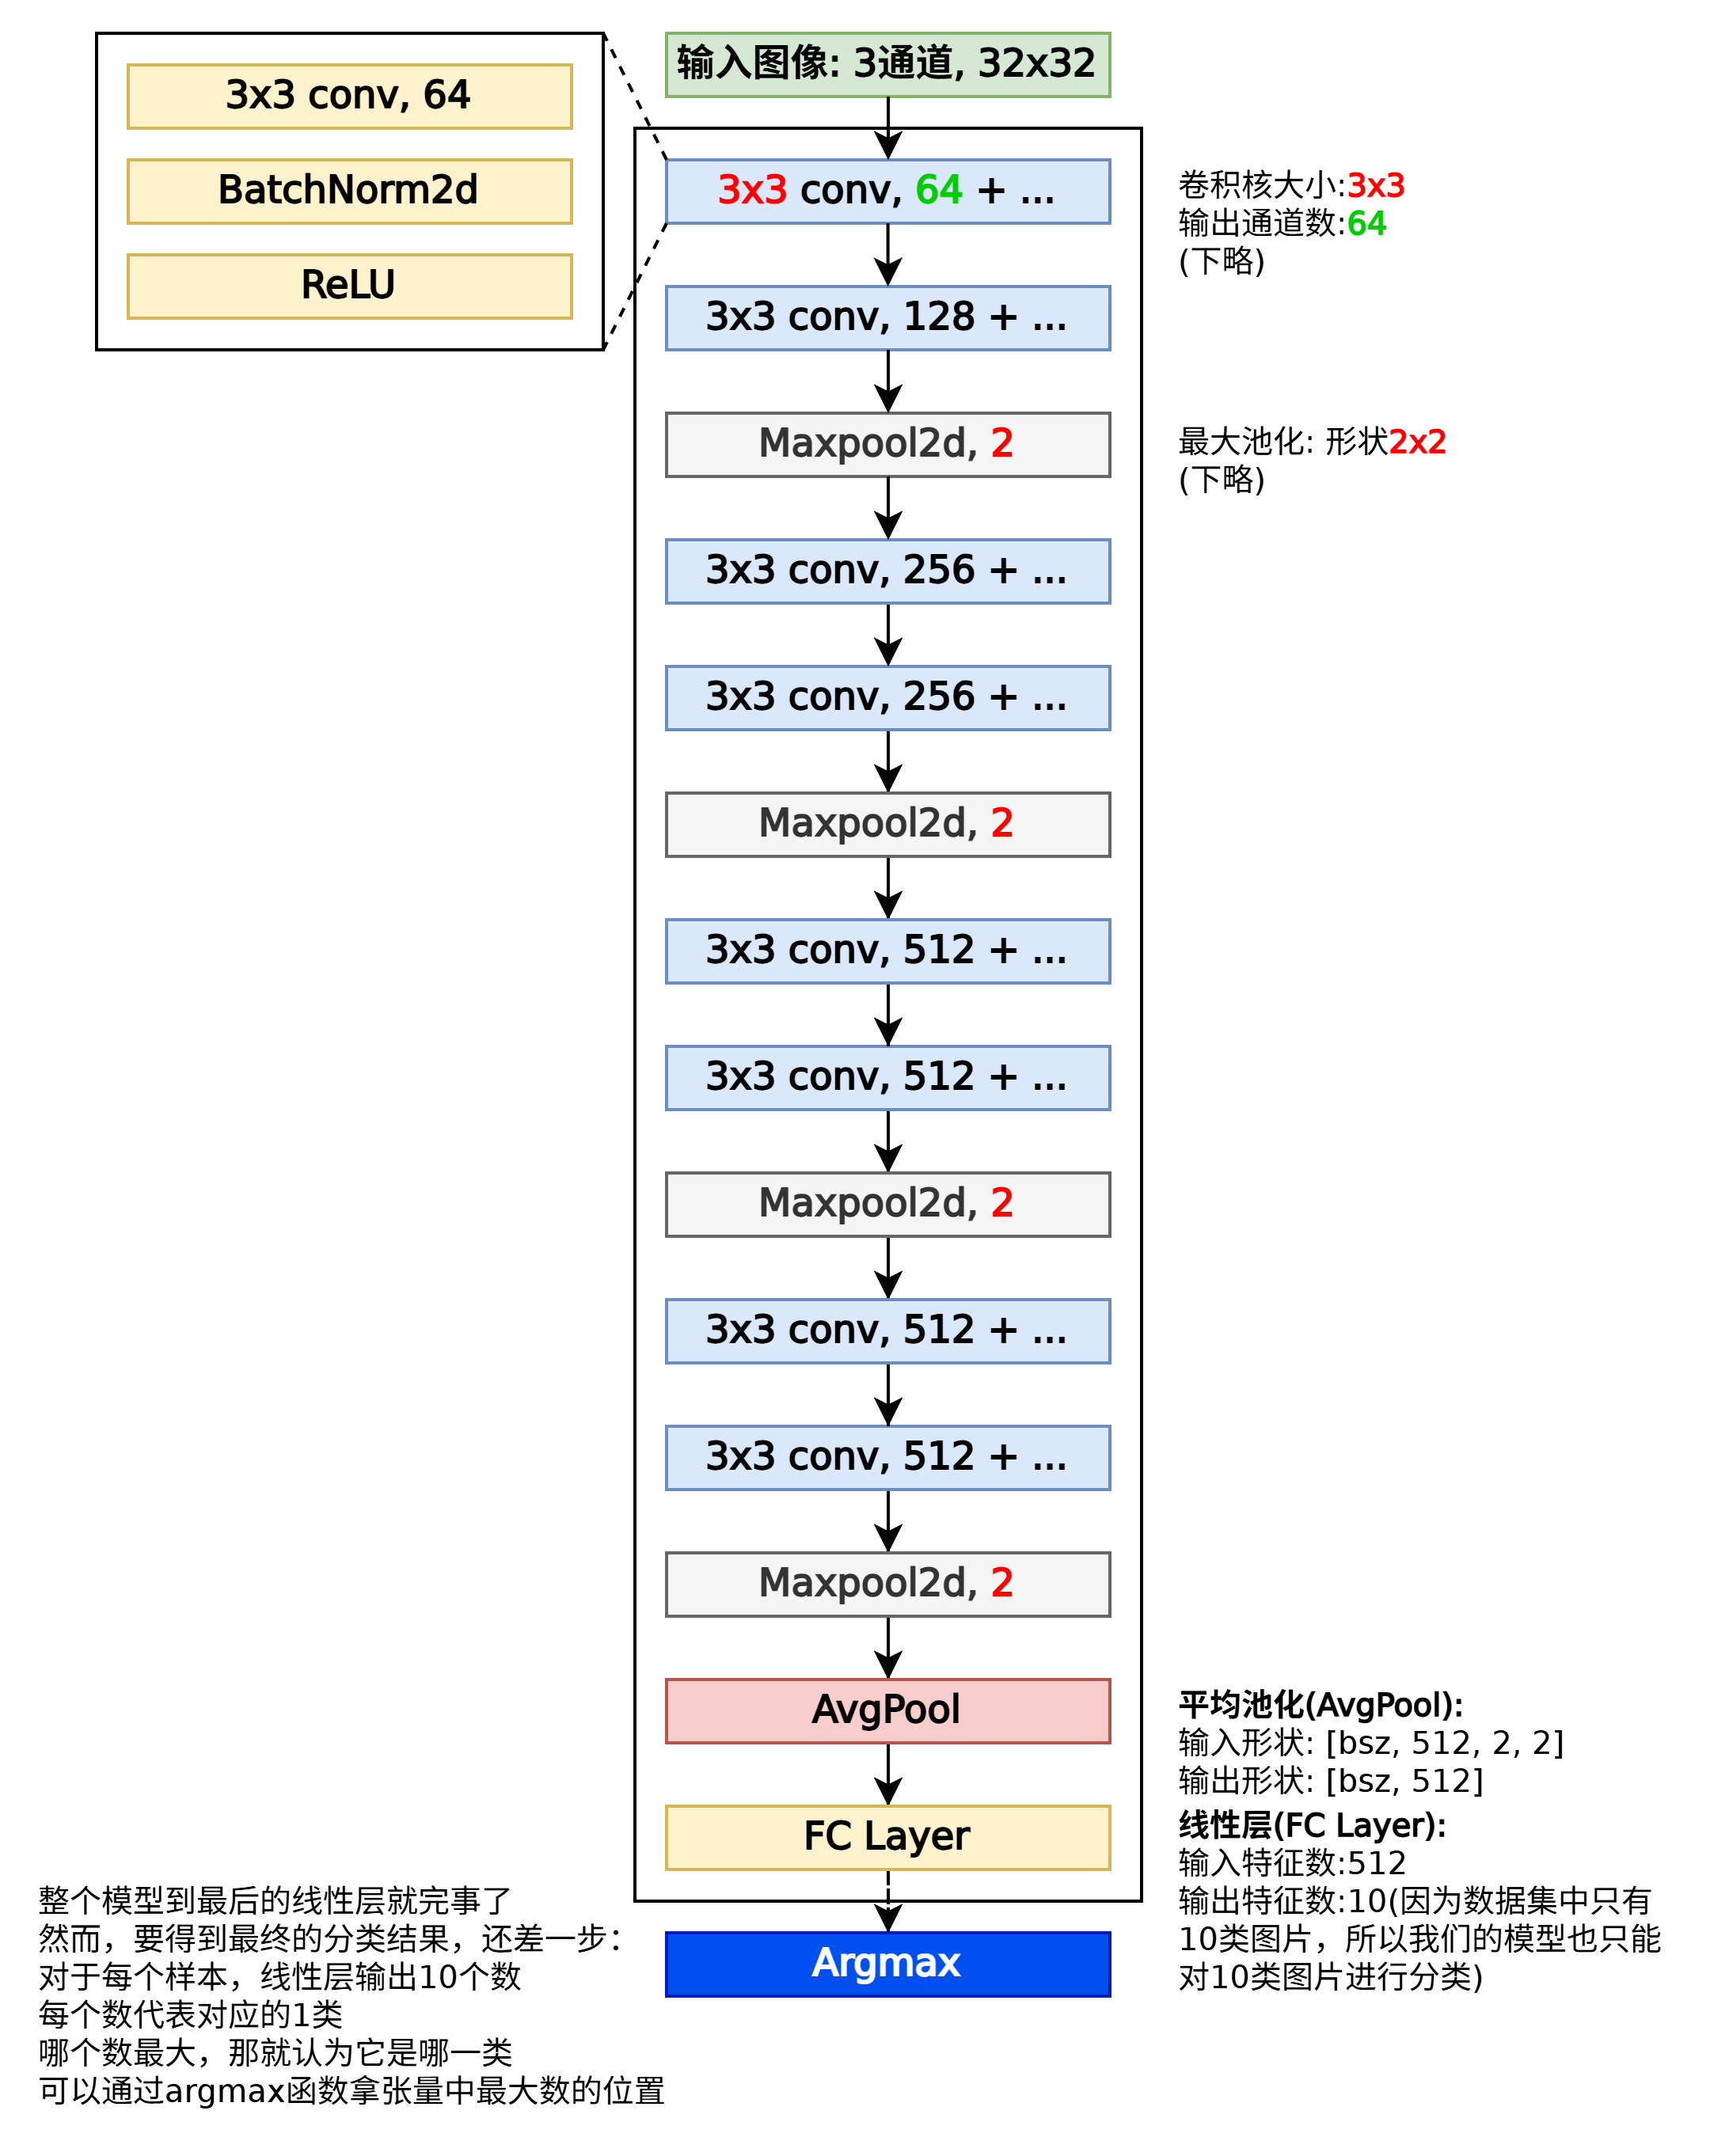



从上图中可以看到，模型中**模块还是比较多的**，那么
- 在实现`__init__()`函数时，可能会用很多行代码，实例化每个模块
- 在实现`forward()`函数时，可能会用很多行代码，调用每个模块，以描述前向过程

好在，在`torch.nn`模块中，还有一个常用的[`torch.nn.Sequential`类](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)。这是一种序列容器，继承自模块类，功能是将一系列计算操作封装成一个序列。使用时：
- **首先在`__init__`方法中**，按照调用顺序，定义所包含的所有操作，**封装到[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)中**；
- **然后在`forward`方法中，调用这个模块**。其会接收参数，并传递给序列中的第一个模块，接下来按顺序将前一个操作的输出传递给下一个模块，依次执行完所有模块后，最终返回最后一个模块的输出。




**请你结合预实验中`nn.Module`的内容，根据上方的架构图，补全下方代码，完成模型的构建**。

> 描述上方模型的方式不止一种，可以在通关实验后，尝试换种方式描述`:)`



In [14]:
class VGG(nn.Module):
  def __init__(self) -> None:
    super().__init__()  # 调用父类的`__init__`函数，完成初始化
    # 如果手动为每个模块，都写一行类似于`self.conv1 = nn.Conv2d(...)`的代码，那疑似有点太累了>_<
    # 所以我们要尝试用一下nn.Sequential了
    layers = [] # 为使用nn.Sequential做准备
    counts = defaultdict(int) # defaultdict是啥？看着像dict的亲戚？
                              # 用它有啥好处？请你通过STFW解决这个问题 :)
    def add(name: str, layer: nn.Module) -> None:      # WoW..原来函数里面还能套函数！
      layers.append((f"{name}{counts[name]}", layer))  # 把(名字, 模块实例)元组先放到一个列表中
      counts[name] += 1

    # 我们注意到，模型主干中只有2种模块: 卷积(卷积/BatchNorm2d/ReLU)和最大池化(Maxpool2d)
    # - 对于卷积模块，卷积核大小均为3x3，只有输入通道和输出通道不同；
    #   而上下层之间是连着的，上一层的 输出通道 便是下一层的 输入通道；
    #   所以理论上只用记录输出通道就可以了（第一个卷积模块的输入通道单独处理）
    # - 对于最大池化，形状均为2x2，没有额外的参数了。
    #
    # 所以，我们甚至可以用一个列表来描述上述模型：
    # - 对于卷积模块，只用输出通道数就可以了
    # - 对于最大池化模块，只需能够和卷积模块分开就可以了
    # 于是，可以写出下面的列表：
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    in_channels = 3 # 第一个卷积模块的输入通道是3
    # 因此，我们可以根据上面的ARCH列表，来实例化模块
    for x in ARCH:
      if x != 'M': # 是卷积模块
        # conv-bn-relu
        # Conv2d模块文档地址: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # BatchNorm2d模块文档地址: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
        # 在JupyterLab中，也可以用Shift+Tab快捷键查看文档哦
        add("conv", nn.Conv2d(in_channels=in_channels,out_channels=x, kernel_size=2, padding=1, bias=False)) # 请你实例化卷积模块，提示：输入通道数是in_channels，输出通道数是x；对应的参数名是什么？请你通过RTFM的方式了解
        add("bn", nn.BatchNorm2d(num_features=x))    # 请你实例化BatchNorm2d模块，提示：输出通道数（特征数）是x
        add("relu", nn.ReLU(True)) # ReLU模块
        in_channels = x # 上一层的输出是下一层的输入
      else:        # 是最大池化模块
        # maxpool
        add("pool", nn.MaxPool2d(2)) # 实例化最大池化模块，形状（核大小）是2x2

    self.backbone = nn.Sequential(OrderedDict(layers)) # 为什么要用OrderedDict？答：文档让我们这么做
    # 对于平均池化，我们可以直接用tensor.mean()处理，就不用实例模块了（也有相关模块可以用）
    self.classifier = nn.Linear(512, 10) # 收个尾，最后一层单独处理下

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x) # 不用为一堆模块写前向传播了...善哉...

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])   # 平均池化

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x) # 请你将平均池化后的结果x，传入上方实例好的`self.classifier`模块进行处理
    return x

定义好模型模块后，那就实例化一下吧！

**直接执行代码块即可，无需补充内容**。

In [15]:
model = VGG().to(my_device) # 如果有GPU卡，那么就将参数移动到GPU的显存上来

我们在预实验中提及过的，可以直接打印模块，以观察模块结构。看看输出是不是能和上面的模型框图对起来？

**直接执行代码块即可，无需补充内容**。

In [16]:
print(model.backbone)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## 定义损失函数、优化器和学习率调度器

### 定义损失函数

根据我们在预实验中所讨论的，为了训练模型，我们还需定义损失函数和优化器。


PyTorch同样提供了常见的损失函数实现，如下表所示。

|    损失函数           |       说明         |
|-----------------------|------------------------|
| [nn.L1Loss()]()           | 计算预测值与真实值的平均绝对误差(MAE)  |
| [nn.MSELoss()](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)         | 计算预测值与真实值的均方误差(MSE)    |
| [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) | 计算预测值与真实值的交叉熵损失函数      |

由于本次训练的模型为分类模型，因而我们选择使用交叉熵函数[`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)。


In [17]:
criterion = nn.CrossEntropyLoss() # 是的，这些损失“函数”也是`nn.Module`的子类；所以，还是实例化一下！

### 定义优化器

> 我们在预实验中已对优化器进行了相关介绍，这里便不详细展开了，但做些简要的回顾
> - 优化器的作用：①在求完梯度后，根据梯度等信息对参数进行更新；②清除梯度。
> - 构建优化器时：需提供 参数列表 和 一些超参数（如学习率等）。对于给定模型/模块，可使用`.parameters()`方法获取所有可训练参数。

本次实验中，我们采用带有动量的随机梯度下降优化器[torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)。

**请你根据上方的介绍，补全下方代码，完成优化器的构建**。

In [18]:
optimizer = SGD(
  params=model.parameters(),       # 为优化器模型的所有可训练参数。我们在上面实例化出的模型变量名为model哦，调用model的什么方法来着？
  lr=0.4,    # 指定学习率为0.4
  momentum=0.9,       # 动量系数0.9
  weight_decay=5e-4,  # 指定L2正则化系数
)

### 定义学习率调度器

在上面定义优化器时，我们指定了**学习率为固定值0.4**；事实上，对于**每一次**前向-反向过程，我们都可以指定**不同的学习率**。

恰好PyTorch提供了[`torch.optim.lr_scheduler.LRScheduler`基类](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)(LR=Learning Rate)，可以**根据当前训练轮数，动态调整学习率**，称之为“**学习率调度器**”。

PyTorch实现了几种学习率调度器，如下所示：

| 名称 | 简介 |
| --- | --- |
| [torch.optim.lr_scheduler.StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) | 等间隔调整 |
| [torch.optim.lr_scheduler.ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html) | 指数衰减 |
| [torch.optim.lr_scheduler.MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html) | 多步长衰减(等间隔调整加强版：可以不等间隔) |
| [torch.optim.lr_scheduler.CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html) | 余弦退火(等间隔调整加强版：可以不等间隔) |

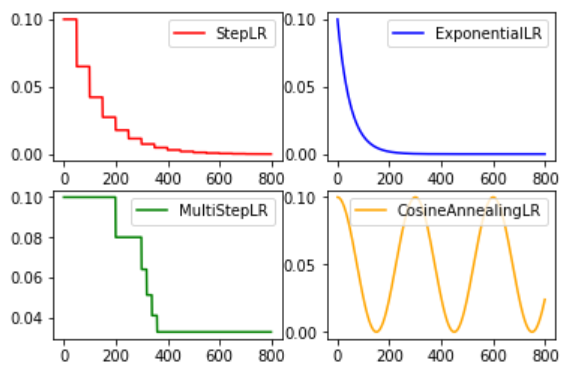

> 横坐标为步数

学习率调度器使用方法也较明了：
- 实例化一个学习率调度器：通常需要我们传入优化器的实例，及相关超参（例如，如果是[等间隔调整StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)，那还需要传入步长等）
- 在优化器更新完参数（`optimizer.step()`）后，再调用学习率调度器实例的`step()`方法

除上述几种现成的学习率调度器外，PyTorch还允许我们通过[torch.optim.lr_scheduler.LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html)**自定义自己的学习率调度器**。

接下来，我们将定义一个“分段线性调度器”，并绘制出迭代步数和学习率关系曲线。

**直接执行代码块即可，无需补充内容**。

> 如果使用CPU进行训练，可以把`num_epochs`调小，以避免在后面训练时等待太长时间。实测`AMD 4800h`需8分钟跑一轮。20轮就得跑近3个多小时。
> 
> 若没有GPU，你可以先完成所有要补充的代码，将文档导出（导出方式见[这里](https://oc.sjtu.edu.cn/courses/75901/modules/items/1406776)）后，到[交我算平台申请`debuga100`资源](https://notes.sjtu.edu.cn/xZjFohuGRRe44Uso0zK7jw)（通常不用排队）完成训练。


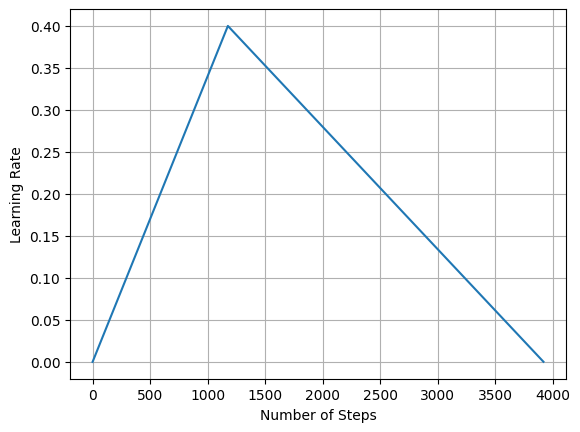

In [19]:
num_epochs = 20 # 设置总训练轮数为20轮
steps_per_epoch = len(dataflow["train"]) # 计算每个epoch包含的步数（数据加载器的长度）

# 定义分段线性调度器: 学习率分三个阶段变化：前30% epoch线性增加，后70% epoch线性衰减到0
def lr_lambda(step):
    return np.interp(                      # numpy提供的一维线性插值实现
        [step / steps_per_epoch],          # 将当前步数转换为epoch进度（含小数）
        [0, num_epochs * 0.3, num_epochs], # 定义三个关键点的横坐标：0%、30%总epoch、100%总epoch
        [0, 1, 0]                          # 定义三个关键点的纵坐标：0、1、0
    )[0]

# 像上面介绍现有学习率调度器那样，可视化我们自己的“分段线性调度器”学习率的变化
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

# 实例化学习率调度器
scheduler = LambdaLR(optimizer, lr_lambda) # 哦，还可以直接传函数名给函数呀！

## 训练模型

> 前面提到，我们采用“小批量梯度下降”法进行优化。再来简要回顾下其思想：
> 
> 在训练模型时，我们通常以“**小批量梯度下降**”(Mini-Batch Gradient Descent)方法进行优化。基本思想是，在单次前向/反向过程中，使用一个**小批量样本**（所有样本中的**一部分**，而非所有样本）的**平均梯度**来近似全局梯度，以减少计算开销并提高收敛速度。**当训练集中所有样本都参与过一次参数更新时，称为训练一轮(epoch)**。

考虑到往往要训练**很多轮**(epoch)才能得到效果较好的模型，于是我们可以**把单个epoch（即对训练集进行一次完整遍历）的优化（前向-反向）过程封装成一个函数**。

**请你结合我们在预实验和上文介绍的内容，补全下方代码**

In [20]:
def train(
  model: nn.Module,     # 参数名后加冒号是干什么的？如果不了解，可以回顾下预实验lab0.1中“类型提示”相关内容
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  model.train() # 考虑到部分模块的训练时行为和推理时行为不一样，
               # 要对模块（在这里是model）调用什么方法，在训练前切换到训练模式来着？
  
  # tqdm是进度条库，可以很直观的展现当前的进度
  # 如果使用的是我们打包好的环境，是装了tqdm的，可以把下面的for替换为如下代码
  # from tqdm.auto import tqdm
  # for inputs, targets in tqdm(dataflow, desc='train', leave=False):
  # 如果使用交我算算力，由于环境中没有tqdm，所以去掉了（

  # 根据“小批量梯度下降”的思想，每次前向-反向过程，只需1个mini-batch的样本而非全部样本；
  # 因为dataflow是DataLoader类的实例，而在前面，我们已借助DataLoader完成了组batch的操作
  # 因此，直接对其迭代即可。每轮迭代得到的张量，即为1个mini-batch；迭代完成后，即遍历了所有样本
  for inputs, targets in dataflow: 
    # 将 输入张量 移动到 模型参数 所在的设备上来
    inputs = inputs.to(my_device)  # 使用什么方法能改变张量数据所在的设备呢？提示：lab0.2有介绍怎么改；我们的目标设备是my_device，my_device在第一个代码块中定义
    targets = targets.to(my_device)  # 使用什么方法能改变张量数据所在的设备呢？

    # 清除梯度
    optimizer.zero_grad() # 调用优化器的什么方法能清除梯度来着？

    # 前向传播
    outputs = model(inputs) # 现在我要做前向传播，模型模块名是`model`，这个`model`其实是`nn.Module`
                           # 输入数据是`inputs`，怎么才能得到模型输出的结果？提示：预实验lab0.3有介绍
    loss = criterion(outputs, targets) # 计算损失函数，得到loss张量

    # 反向传播
    loss.backward()  # 我已经算出来loss这个张量了，现在我想求模型中各个参数对loss的梯度
                       # 调用张量的什么方法可以完成反向传播来着？提示：预实验lab0.3有介绍

    # 借助优化器更新参数
    optimizer.step() # 调用优化器的什么方法，可以使之根据梯度，更新参数来着？提示：预实验lab0.3有介绍
    # 借助学习率调度器更新下一次迭代时的学习率
    scheduler.step() # 需要调用学习率调度器的什么方法呢？提示：往上翻一点，刚刚介绍过

**我们想在每轮训练完成后，看一下目前的模型在测试集上的表现如何**。因此，接下来我们定义一个**只做推理(前向过程)**的**评估函数**，能够遍历**测试集**，并返回准确率。

**直接执行代码块即可，无需补充内容**。

In [21]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader
) -> float:
  model.eval() # 考虑到部分模块的训练时行为和推理时行为不一样，
               # 因为我们在评估时只做推理，所以我们将其切换到`eval`模式

  num_samples = 0
  num_correct = 0

  for inputs, targets in dataflow:
    # 这是在干啥？相信你在定义过上面的单轮训练后，心中已经有答案了
    inputs = inputs.to(my_device)
    targets = targets.to(my_device)

    # 前向传播
    outputs = model(inputs)

    # 对于每个样本，模型都会输出10个数；看哪个最大，样本就属于哪一类
    outputs = outputs.argmax(dim=1)

    # 更新统计量
    num_samples += targets.shape[0]
    num_correct += (outputs == targets).sum() # `outputs == targets`会返回一个布尔值张量，对其求和，就能拿到正确识别的样本数目

  return (num_correct / num_samples * 100).item() # 返回正确率

呼呼！做了这么多准备工作，万事俱备，只欠东风\~因为要训练很多轮，所以我们套个循环\~

> 如果训练20轮的话，最终模型的准确率应在92%以上

In [22]:
for epoch_num in range(1, num_epochs + 1):
  # 为训练函数传入我们上面定义好的模型、训练集DataLoader、损失函数、优化器、学习率调整器
  train(model, dataflow["train"], criterion, optimizer, scheduler)
  # 为评估函数传入我们上面定义好的模型、测试集DataLoader
  metric = evaluate(model, dataflow["test"])
  print(f"epoch {epoch_num}:", metric)

epoch 1: 43.97999954223633
epoch 2: 58.34000015258789
epoch 3: 57.08000183105469
epoch 4: 55.790000915527344
epoch 5: 52.04999923706055
epoch 6: 61.31999969482422
epoch 7: 67.70999908447266
epoch 8: 69.87999725341797
epoch 9: 59.95999526977539
epoch 10: 62.290000915527344
epoch 11: 70.0
epoch 12: 71.3499984741211
epoch 13: 74.16999816894531
epoch 14: 72.66999816894531
epoch 15: 80.54999542236328
epoch 16: 77.04000091552734
epoch 17: 82.73999786376953
epoch 18: 87.79000091552734
epoch 19: 89.54000091552734
epoch 20: 91.66999816894531


## 检验训练成果

至此，我们已经完成了模型的训练。虽然能看到准确率数字，但还是想更“形象”的看一下模型效果。运行下方代码块，看看刚刚训出来的模型是不是真的能够识别图像？

**直接执行代码块即可，无需补充内容**。

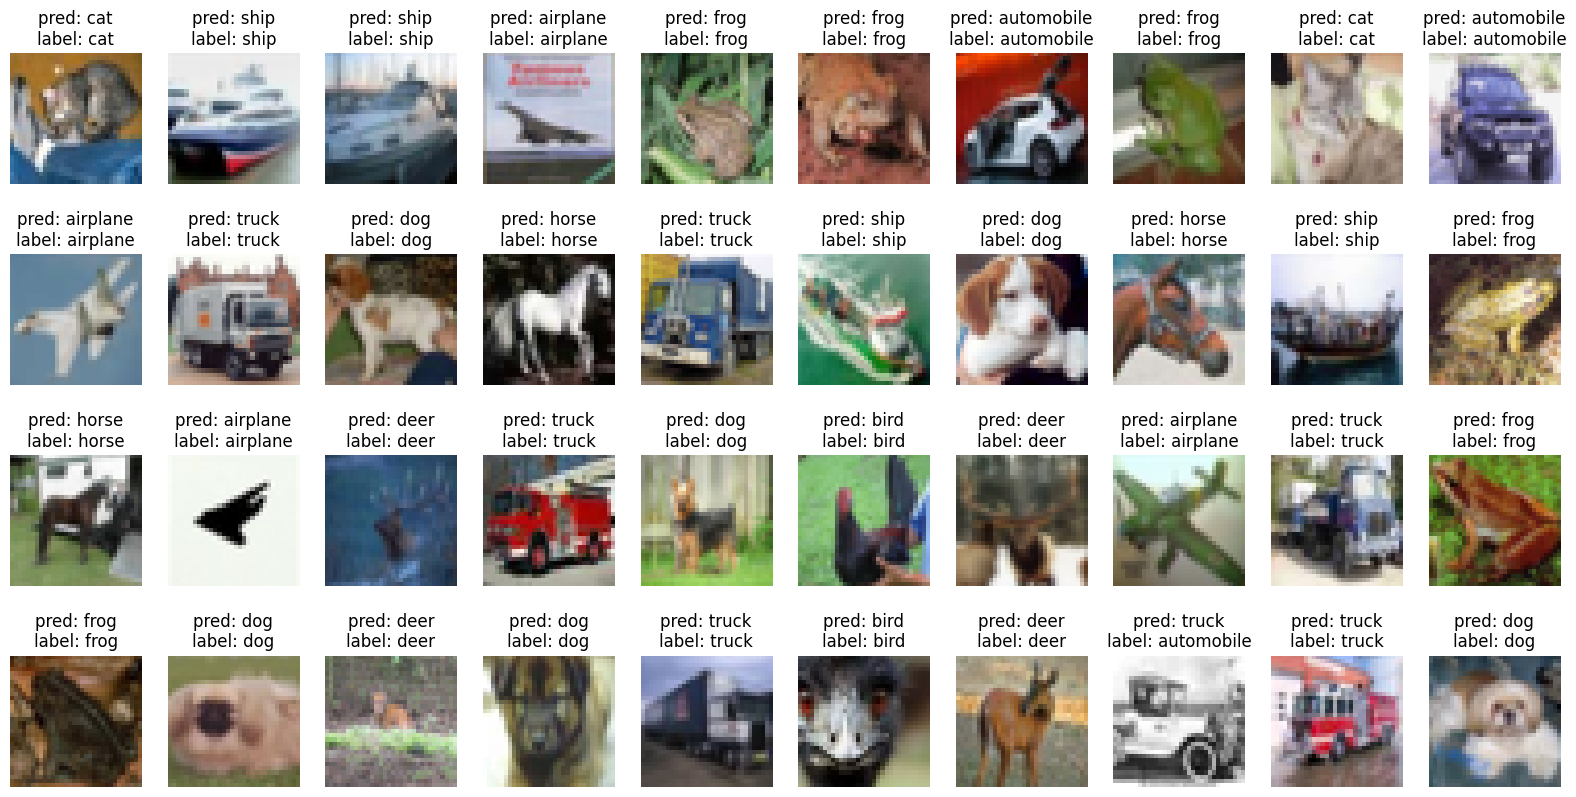

In [23]:
plt.figure(figsize=(20, 10))  # 创建一个20英寸宽、10英寸高的画布用于显示图像

for index in range(40):  # 遍历测试集前40个样本
    image, label = dataset["test"][index]  # 获取测试集的第index个图像和真实标签

    # 模型推理开始
    model.eval()  # 设置模型为评估模式
    with torch.inference_mode():  # 禁用梯度计算，提升推理速度
        pred = model(image.unsqueeze(dim=0).cuda())  # 给图像增加批次维度并送入GPU，模型预测
        pred = pred.argmax(dim=1)  # 在类别维度取最大值索引，得到预测类别

    # 图像格式转换
    image = image.permute(1, 2, 0)  # 将图像维度从[通道, 高, 宽]转换为[高, 宽, 通道]（matplotlib要求格式）

    # 标签转换
    pred = dataset["test"].classes[pred]  # 将预测的类别索引转换为类别名称
    label = dataset["test"].classes[label]  # 将真实标签的类别索引转换为类别名称

    # 可视化设置
    plt.subplot(4, 10, index + 1)  # 在4行10列的网格中，创建第index+1个子图位置
    plt.imshow(image)  # 显示图像
    plt.title(f"pred: {pred}" + "\n" + f"label: {label}")  # 设置子图标题，显示预测/真实标签
    plt.axis("off")  # 关闭坐标轴显示
    
plt.show()  # 显示所有子图


## 参考资料

[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)

[《智能计算系统》第二版](#)

[MIT 6.5940 EfficientML.ai](https://hanlab.mit.edu/course)

# 尾声

**至此，我们已从头训练了一个模型，并能够让模型跑起来了**。但是，我们想让模型在不损失精度的条件下跑的更快，更省资源！这就需要一些手段对模型进行**优化**。我们将在最后2次实验中，对本次实验课训练出的模型，通过**稀疏**和**量化**两种手段进行优化。

关于本文档有任何疑问，或者揪出了Bug，亦或有建议、吐槽，欢迎找老师、助教反馈。本次实验反馈问卷链接：https://wj.sjtu.edu.cn/q/mjsw5saG 期待听到大家的声音！